In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('creditcard.csv')

from sklearn.preprocessing import StandardScaler, RobustScaler

# FEATURE SCALING EXPLANATION:
#   - Using RobustScaler for Amount is recommended because:
#     1. Transaction amounts often contain extreme outliers (e.g., very large purchases)
#     2. RobustScaler uses median and IQR (Interquartile Range), making it resistant to outliers

df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

X_base, X_test, y_base, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [27]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve
import time

def evaluate_sampling_strategy(sampling_method, X_train, y_train, X_val, y_val):

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.5,
        random_state=42,
        n_jobs=-1,
    )

    if sampling_method == 'SMOTE':
        smote = SMOTE(sampling_strategy=0.1, random_state=42, k_neighbors=3)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    elif sampling_method == 'Under-Sampling':
        # Notice that the sampling is only on training data, that is why creating df_train rather than
        # using df directly
        df_train = pd.concat([X_train, y_train], axis=1)
        df_normal = df_train[df_train['Class'] == 0]
        df_fraud = df_train[df_train['Class'] == 1]
        df_normal_sampled = df_normal.sample(n=len(df_fraud), random_state=42)
        df_balanced = pd.concat([df_normal_sampled, df_fraud])

        X_resampled = df_balanced.drop('Class', axis=1)
        y_resampled = df_balanced['Class']
    else:
        X_resampled, y_resampled = X_train, y_train

    start_time = time.time()
    model.fit(X_resampled, y_resampled)
    training_time = time.time() - start_time

    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    conf_matrix = confusion_matrix(y_val, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()
    recall = TP / (TP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    pr_auc = average_precision_score(y_val, y_pred_proba)

    return {
        'method': sampling_method,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'pr_auc': pr_auc,
        'training_time': training_time,
        'confusion_matrix': conf_matrix
    }


In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {'SMOTE':[], 'Under-Sampling':[], 'No-Sampling':[]}

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_base, y_base)):
    print(f'\n{'='*30} Fold {fold_idx} {'='*30}')
    X_train, X_val = X_base.iloc[train_idx], X_base.iloc[val_idx]
    y_train, y_val = y_base.iloc[train_idx], y_base.iloc[val_idx]

    for method in ['SMOTE', 'Under-Sampling', 'No-Sampling']:
        fold_result = evaluate_sampling_strategy(method, X_train, y_train, X_val, y_val)
        results[method].append(fold_result)
        print(f'{method} :Recall = {fold_result['recall']:.4f}, Precision = {fold_result['precision']:.4f}, F1 = {fold_result['f1']:.4f}')


============================== Fold 0 ==============================
SMOTE :Recall = 0.7949, Precision = 0.8493, F1 = 0.8212
Under-Sampling :Recall = 0.9359, Precision = 0.0385, F1 = 0.0739
No-Sampling :Recall = 0.6667, Precision = 0.9630, F1 = 0.7879

============================== Fold 1 ==============================
SMOTE :Recall = 0.7342, Precision = 0.8788, F1 = 0.8000
Under-Sampling :Recall = 0.8861, Precision = 0.0459, F1 = 0.0873
No-Sampling :Recall = 0.5190, Precision = 1.0000, F1 = 0.6833

============================== Fold 2 ==============================
SMOTE :Recall = 0.7215, Precision = 0.8507, F1 = 0.7808
Under-Sampling :Recall = 0.8734, Precision = 0.0589, F1 = 0.1103
No-Sampling :Recall = 0.6835, Precision = 0.9643, F1 = 0.8000

============================== Fold 3 ==============================
SMOTE :Recall = 0.8481, Precision = 0.7882, F1 = 0.8171
Under-Sampling :Recall = 0.9367, Precision = 0.0460, F1 = 0.0876
No-Sampling :Recall = 0.6582, Precision = 0.9123, 

In [29]:
summary_dfs = {}
for method, fold_results in results.items():
    df_method = pd.DataFrame(fold_results)
    df_method['fold'] = range(1, len(fold_results)+1)
    summary_dfs[method] = df_method

    # Print summary
    print(f"\n{method} Performance:")
    print(f"Average Recall: {df_method['recall'].mean():.4f}")
    print(f"Average Precision: {df_method['precision'].mean():.4f}")
    print(f"Average F1-Score: {df_method['f1'].mean():.4f}")
    print(f"Average PR-AUC: {df_method['pr_auc'].mean():.4f}")
    print(f"Average Training Time: {df_method['training_time'].mean():.2f} sec")


SMOTE Performance:
Average Recall: 0.7767
Average Precision: 0.8481
Average F1-Score: 0.8092
Average PR-AUC: 0.7514
Average Training Time: 0.37 sec

Under-Sampling Performance:
Average Recall: 0.9062
Average Precision: 0.0461
Average F1-Score: 0.0877
Average PR-AUC: 0.7243
Average Training Time: 0.17 sec

No-Sampling Performance:
Average Recall: 0.6219
Average Precision: 0.9596
Average F1-Score: 0.7521
Average PR-AUC: 0.8207
Average Training Time: 0.31 sec


In [30]:
# FINAL MODEL TRAINING WITH BEST SAMPLING METHOD
print("\n" + "="*50)
print("Training Final XGBoost Model with Best Sampling Strategy")
print("="*50)

best_method = max(results, key=lambda k: np.mean([r['f1'] for r in results[k]]))
print(f"Selected best sampling method: {best_method}")

if best_method == 'SMOTE':
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_resampled, y_resampled = smote.fit_resample(X_base, y_base)
elif best_method == 'Under-sampling':
    df_base = pd.concat([X_base, y_base], axis=1)
    df_normal = df_base[df_base['Class'] == 0]
    df_fraud = df_base[df_base['Class'] == 1]
    df_normal_sampled = df_normal.sample(n=len(df_fraud), random_state=42)
    balanced_df = pd.concat([df_normal_sampled, df_fraud])
    X_resampled = balanced_df.drop('Class', axis=1)
    y_resampled = balanced_df['Class']
else:
    X_resampled, y_resampled = X_base, y_base

# Train final model on full base data
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
final_model.fit(X_resampled, y_resampled)
training_time = time.time() - start_time
print(f"Final model trained in {training_time:.2f} seconds")


Training Final XGBoost Model with Best Sampling Strategy
Selected best sampling method: SMOTE
Final model trained in 2.47 seconds


In [31]:
# Make predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate key metrics
TN, FP, FN, TP = conf_matrix.ravel()
fraud_recall = TP / (TP + FN)
fraud_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_score = 2 * (fraud_precision * fraud_recall) / (fraud_precision + fraud_recall) if (fraud_precision + fraud_recall) > 0 else 0

print(f"\nFraud-Specific Metrics:")
print(f"Recall (Sensitivity): {fraud_recall:.4f} - Ability to detect actual frauds")
print(f"Precision: {fraud_precision:.4f} - Accuracy when predicting fraud")
print(f"F1-Score: {f1_score:.4f} - Balance between precision and recall")
print(f"False Positive Rate: {FP/(FP+TN):.4f} - Normal transactions misclassified as fraud")


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.69      0.86      0.77        98

    accuracy                           1.00     56962
   macro avg       0.85      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56827    37]
 [   14    84]]

Fraud-Specific Metrics:
Recall (Sensitivity): 0.8571 - Ability to detect actual frauds
Precision: 0.6942 - Accuracy when predicting fraud
F1-Score: 0.7671 - Balance between precision and recall
False Positive Rate: 0.0007 - Normal transactions misclassified as fraud


/var/folders/rf/fk21z0nj7wvc4x6py1jjp8dm0000gn/T/ipykernel_67573/1201874553.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='method', y='training_time', data=pd.concat(summary_dfs.values()),
/var/folders/rf/fk21z0nj7wvc4x6py1jjp8dm0000gn/T/ipykernel_67573/1201874553.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='training_time', data=pd.concat(summary_dfs.values()),


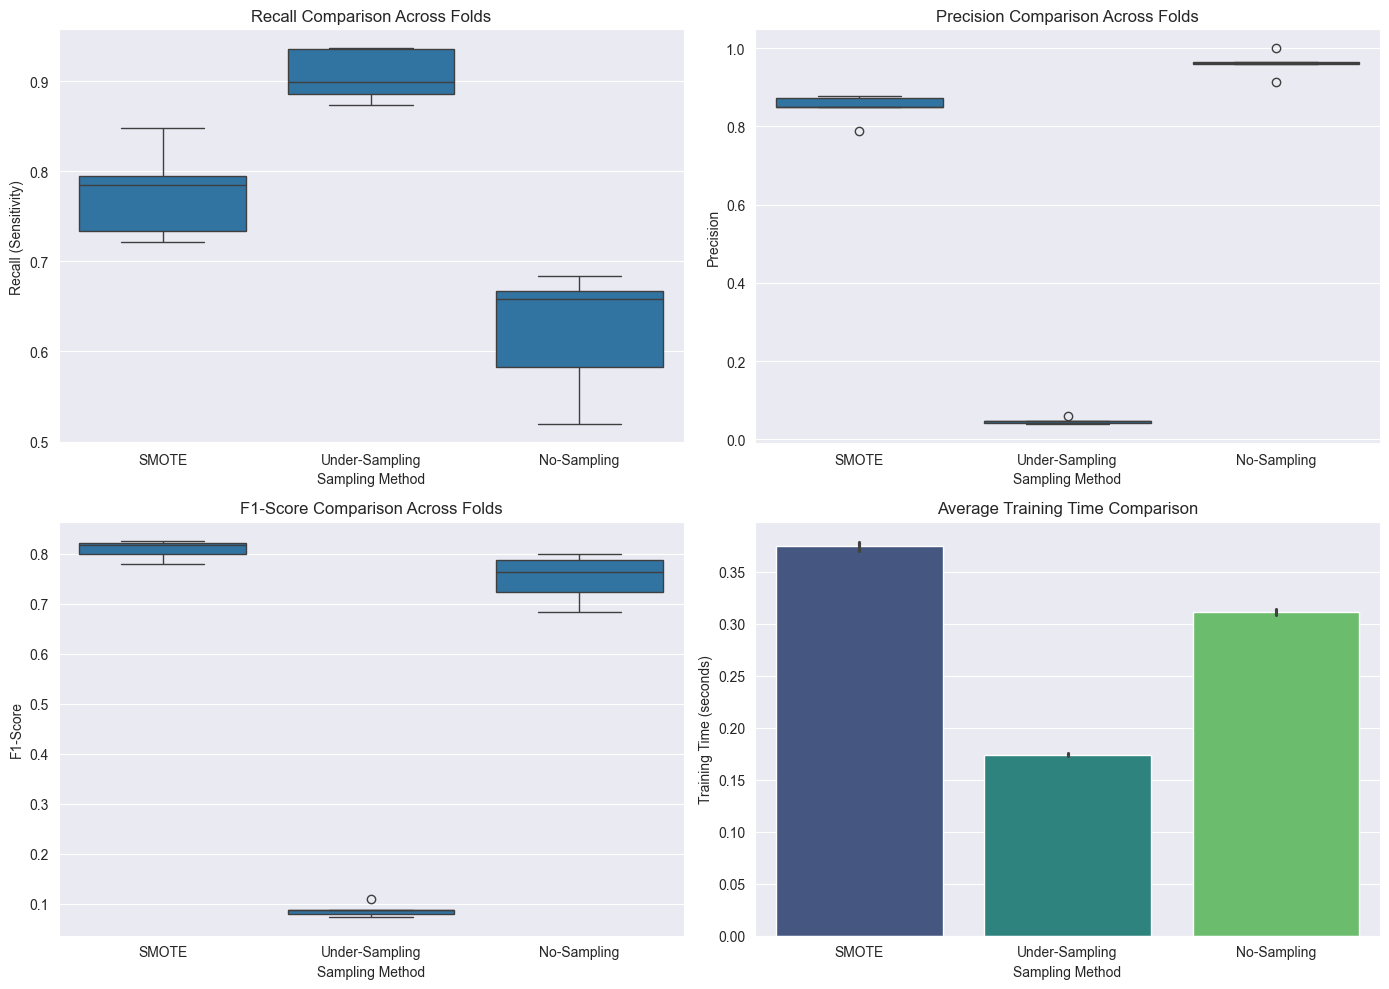

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 10))

# Recall Comparison
plt.subplot(2, 2, 1)
sns.boxplot(x='method', y='recall', data=pd.concat(summary_dfs.values()))
plt.title('Recall Comparison Across Folds')
plt.ylabel('Recall (Sensitivity)')
plt.xlabel('Sampling Method')

# Precision Comparison
plt.subplot(2, 2, 2)
sns.boxplot(x='method', y='precision', data=pd.concat(summary_dfs.values()))
plt.title('Precision Comparison Across Folds')
plt.ylabel('Precision')
plt.xlabel('Sampling Method')

# F1-Score Comparison
plt.subplot(2, 2, 3)
sns.boxplot(x='method', y='f1', data=pd.concat(summary_dfs.values()))
plt.title('F1-Score Comparison Across Folds')
plt.ylabel('F1-Score')
plt.xlabel('Sampling Method')

# Training Time Comparison
plt.subplot(2, 2, 4)
sns.barplot(x='method', y='training_time', data=pd.concat(summary_dfs.values()),
            estimator=np.mean, ci='sd', palette='viridis')
plt.title('Average Training Time Comparison')
plt.ylabel('Training Time (seconds)')
plt.xlabel('Sampling Method')

plt.tight_layout()
plt.show()

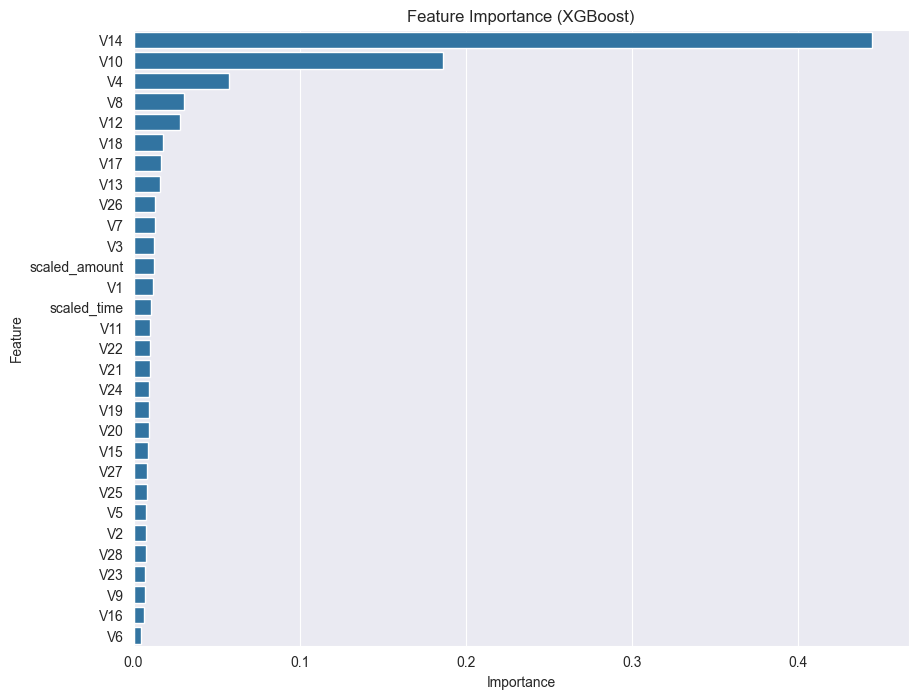

In [33]:
feature_importance = pd.DataFrame({
    'Feature': X_resampled.columns,  # 特征名称
    'Importance': final_model.feature_importances_  # 特征重要性分数（0~1，总和不一定为1）
})

# 按重要性降序排序
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# 3. 可视化特征重要性（展示所有特征）
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (XGBoost)')
plt.show()


Performance at Different Thresholds:
 Threshold   Recall  Precision  F1-Score      FPR
      0.05 0.897959   0.221106  0.354839 0.005452
      0.10 0.897959   0.363636  0.517647 0.002708
      0.15 0.887755   0.430693  0.580000 0.002022
      0.20 0.887755   0.494318  0.635036 0.001565
      0.25 0.887755   0.543750  0.674419 0.001284
      0.30 0.877551   0.573333  0.693548 0.001125
      0.35 0.867347   0.615942  0.720339 0.000932
      0.40 0.867347   0.648855  0.742358 0.000809
      0.45 0.867347   0.669291  0.755556 0.000739
      0.50 0.857143   0.694215  0.767123 0.000651
      0.55 0.857143   0.763636  0.807692 0.000457
      0.60 0.846939   0.790476  0.817734 0.000387
      0.65 0.846939   0.798077  0.821782 0.000369
      0.70 0.846939   0.798077  0.821782 0.000369
      0.75 0.846939   0.830000  0.838384 0.000299
      0.80 0.846939   0.855670  0.851282 0.000246
      0.85 0.826531   0.852632  0.839378 0.000246
      0.90 0.816327   0.869565  0.842105 0.000211

Optimal Thr

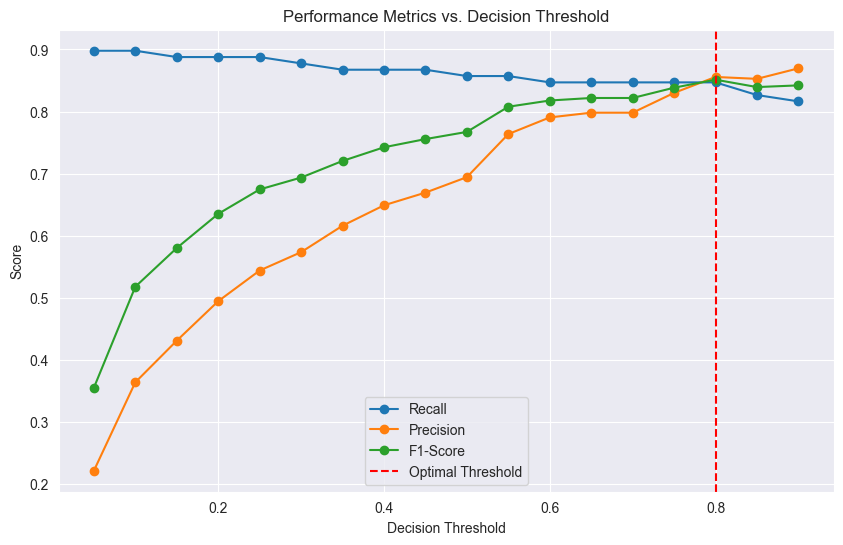

In [34]:
thresholds = np.arange(0.05, 0.95, 0.05)
results_thresh = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_thresh)
    TN, FP, FN, TP = conf_matrix.ravel()

    recall = TP / (TP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = FP / (FP + TN)

    results_thresh.append({
        'Threshold': thresh,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'FPR': fpr
    })

# Create results dataframe
results_df = pd.DataFrame(results_thresh)
print("\nPerformance at Different Thresholds:")
print(results_df[['Threshold', 'Recall', 'Precision', 'F1-Score', 'FPR']].to_string(index=False))

# Find optimal threshold based on F1-score
optimal_row = results_df.iloc[results_df['F1-Score'].idxmax()]
print(f"\nOptimal Threshold (Max F1-Score): {optimal_row['Threshold']:.2f}")
print(f"At this threshold:")
print(f"- Recall: {optimal_row['Recall']:.4f}")
print(f"- Precision: {optimal_row['Precision']:.4f}")
print(f"- F1-Score: {optimal_row['F1-Score']:.4f}")
print(f"- False Positive Rate: {optimal_row['FPR']:.4f}")

# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='o')
plt.axvline(x=optimal_row['Threshold'], color='r', linestyle='--', label='Optimal Threshold')
plt.title('Performance Metrics vs. Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()